In [103]:
import ROOT
import numpy as np
import os
import matplotlib.pyplot as plt
from array import array
from scipy.optimize import minimize_scalar
import math

def plot_yield_scaler(run, current, correction):
    filename = f"/lustre24/expphy/cache/hallc/c-nps/analysis/pass1/replays/skim/nps_hms_skim_{run}_1_-1.root"
    
    if not os.path.isfile(filename):
        print(f"Error: File not found for run {run}")
        return -1

    data_file = ROOT.TFile.Open(filename)
    scaler_tree = data_file.Get("TSH")
    t_tree = data_file.Get("T")
    if not scaler_tree:
        print(f"Error: Couldn't find scaler tree 'TSH' in file {filename}")
        return -1

    # Define ROOT-compatible arrays
    H_BCM4A_scalerCharge = array('d', [0.])
    H_BCM4A_scalerCurrent = array('d', [0.])
    H_BCM4A_scaler = array('d', [0.])
    H_EDTM_scaler = array('d', [0.])
    H_hTRIG4_scaler = array('d', [0.])
    H_1MHz_scalerTime = array('d', [0.])
    H_cal_etottracknorm = array('d', [0.])

    scaler_tree.SetBranchAddress("H.BCM4A.scalerCharge", H_BCM4A_scalerCharge)
    scaler_tree.SetBranchAddress("H.BCM4A.scalerCurrent", H_BCM4A_scalerCurrent)
    scaler_tree.SetBranchAddress("H.BCM4A.scaler", H_BCM4A_scaler)
    scaler_tree.SetBranchAddress("H.EDTM.scaler", H_EDTM_scaler)
    scaler_tree.SetBranchAddress("H.hTRIG4.scaler", H_hTRIG4_scaler)
    scaler_tree.SetBranchAddress("H.1MHz.scalerTime", H_1MHz_scalerTime)
    t_tree.SetBranchAddress("H.cal.etottracknorm", H_cal_etottracknorm)

    nentries = scaler_tree.GetEntries()
    if nentries < 2:
        print(f"Error: Not enough scaler entries in run {run}")
        return -1

    accumulated_charge = 0
    accumulated_edtm = 0
    accumulated_hTRIG4 = 0
    prev_time = 0
    prev_EDTM = 0
    prev_hTRIG4 = 0
    prev_BCM4A_scaler = 0

    for i in range(nentries - 1):
        scaler_tree.GetEntry(i)

        if i == 0:
            prev_time = H_1MHz_scalerTime[0]
            prev_EDTM = H_EDTM_scaler[0]
            prev_hTRIG4 = H_hTRIG4_scaler[0]
            prev_BCM4A_scaler = H_BCM4A_scaler[0]
            continue

        delta_time = H_1MHz_scalerTime[0] - prev_time
        delta_trig4 = H_hTRIG4_scaler[0] - prev_hTRIG4

        if abs(H_BCM4A_scalerCurrent[0] - current) < 1.0 :

            rate = ((H_BCM4A_scaler[0] - prev_BCM4A_scaler) / (H_1MHz_scalerTime[0] - prev_time))

            corrected_current = H_BCM4A_scalerCurrent[0] + correction*math.sqrt(rate) # form of corrected current from (2muA/sqrt(rate))
            # corrected_current = H_BCM4A_scalerCurrent[0] + correction # form of corrected current from KaonLT
            
            accumulated_charge += corrected_current * delta_time
            accumulated_edtm += (H_EDTM_scaler[0] - prev_EDTM)
            accumulated_hTRIG4 += delta_trig4

        prev_time = H_1MHz_scalerTime[0]
        prev_EDTM = H_EDTM_scaler[0]
        prev_hTRIG4 = H_hTRIG4_scaler[0]
        prev_BCM4A_scaler = H_BCM4A_scaler[0]

    data_file.Close()

    if accumulated_charge <= 0:
        print(f"Warning: Accumulated charge is zero or negative for run {run}")
        print(accumulated_charge)
        return -1

    yield_norm = (accumulated_hTRIG4 - accumulated_edtm) / accumulated_charge
    return yield_norm



# Define cost function: we want normalized yields to be as close to 1 as possible
def cost_function(correction, runs, currents):
    yields = []
    for run, current in zip(runs, currents):
        y = plot_yield_scaler(run, current, correction)
        if y > 0:
            yields.append(y)
        else:
            return 1e6  # penalize invalid values

    if len(yields) == 0:
        return 1e6

    yields = np.array(yields)
    normalized_yields = yields / np.min(yields)

    # Cost: sum of squared deviations from 1
    cost = np.sum((normalized_yields - 1) ** 2)
    return cost



In [109]:
# ------------ Analysis Driver ------------
runs = [1523, 1524, 1525, 1526, 1528, 1530] #carbon 1
currents = [33.5, 33.5, 38.5, 24, 14, 4.8] # carbon 1

# runs = [6845, 6846, 6847, 6848, 6849] # carbon 2
# currents = [5.1, 20.5, 15.3, 10.5, 3] # carbon 2

# runs = [7003, 7004, 7005, 7006, 7007]  # carbon 3
# currents = [39.5, 29.5, 19.6, 10, 5]         # carbon 3

# Use scipy to optimize the correction factor
result = minimize_scalar(cost_function, bounds=(-0.1, 0.1), args=(runs, currents), method='bounded')

optimal_correction = result.x
print(f"Optimal correction: {optimal_correction:.5f}")

-104.92338036036729
Optimal correction: -0.00116


Zero Correction | Processing run 1523 at 33.5 uA
  Run 1523: Yield/Charge = 100.88041049385843
Zero Correction | Processing run 1524 at 33.5 uA
  Run 1524: Yield/Charge = 100.99008723410758
Zero Correction | Processing run 1525 at 38.5 uA
  Run 1525: Yield/Charge = 100.96642355138341
Zero Correction | Processing run 1526 at 24 uA
  Run 1526: Yield/Charge = 100.79023302565115
Zero Correction | Processing run 1528 at 14 uA
  Run 1528: Yield/Charge = 100.12061426081851
Zero Correction | Processing run 1530 at 4.8 uA
  Run 1530: Yield/Charge = 97.6514038843196
Optimal Correction = -0.0012 | Processing run 1523 at 33.5 uA
  Run 1523: Yield/Charge = 102.90105715675058
Optimal Correction = -0.0012 | Processing run 1524 at 33.5 uA
  Run 1524: Yield/Charge = 103.01588014863935
Optimal Correction = -0.0012 | Processing run 1525 at 38.5 uA
  Run 1525: Yield/Charge = 102.8556852130466
Optimal Correction = -0.0012 | Processing run 1526 at 24 uA
  Run 1526: Yield/Charge = 103.18455907193318
Optimal 

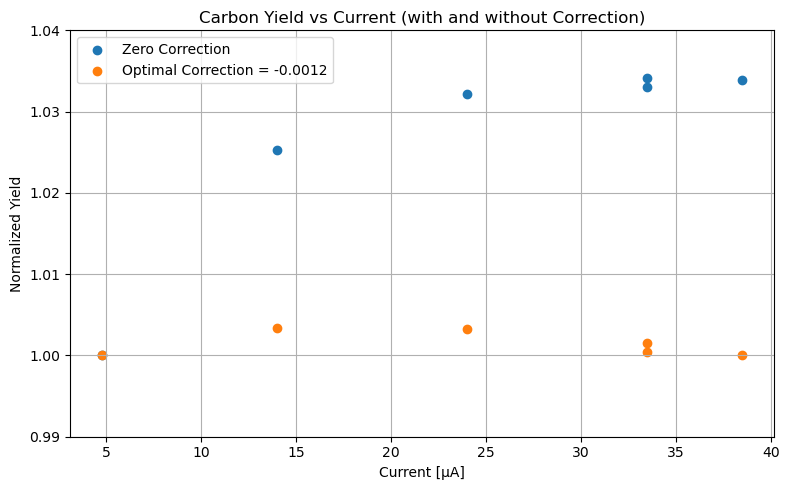

In [110]:
corrections = {
    f"Zero Correction": 0.0,
    f"Optimal Correction = {optimal_correction:.4f}": optimal_correction  # Display value in legend
}

plt.figure(figsize=(8, 5))

for label, correction in corrections.items():
    yields = []
    valid_currents = []

    for run, current in zip(runs, currents):
        print(f'{label} | Processing run {run} at {current} uA')
        y = plot_yield_scaler(run, current, correction)
        if y > 0:
            print(f"  Run {run}: Yield/Charge = {y}")
            yields.append(y)
            valid_currents.append(current)
        else:
            print("Invalid or zero yield")

    if yields:
        min_yield = min(yields)
        normalized_yields = [y / min_yield for y in yields]

        plt.scatter(valid_currents, normalized_yields, label=label)

plt.xlabel('Current [μA]')
plt.ylabel('Normalized Yield')
plt.title('Carbon Yield vs Current (with and without Correction)')
plt.grid(True)
plt.ylim(0.99, 1.04)
plt.legend()
plt.tight_layout()
plt.show()



Processing dataset: LH2 1
  Zero Correction | Run 1514 at 5 uA
    Yield/Charge = 414.29049200665145
  Zero Correction | Run 1515 at 10 uA
    Yield/Charge = 422.13286337420254
  Zero Correction | Run 1516 at 15 uA
    Yield/Charge = 421.9858549222546
  Zero Correction | Run 1517 at 25 uA
    Yield/Charge = 423.1593298062713
  Optimal Correction = -0.0012 | Run 1514 at 5 uA
    Yield/Charge = 436.18408658911727
  Optimal Correction = -0.0012 | Run 1515 at 10 uA
    Yield/Charge = 438.0090014121679
  Optimal Correction = -0.0012 | Run 1516 at 15 uA
    Yield/Charge = 434.95019055771377
  Optimal Correction = -0.0012 | Run 1517 at 25 uA
    Yield/Charge = 433.1497635838823


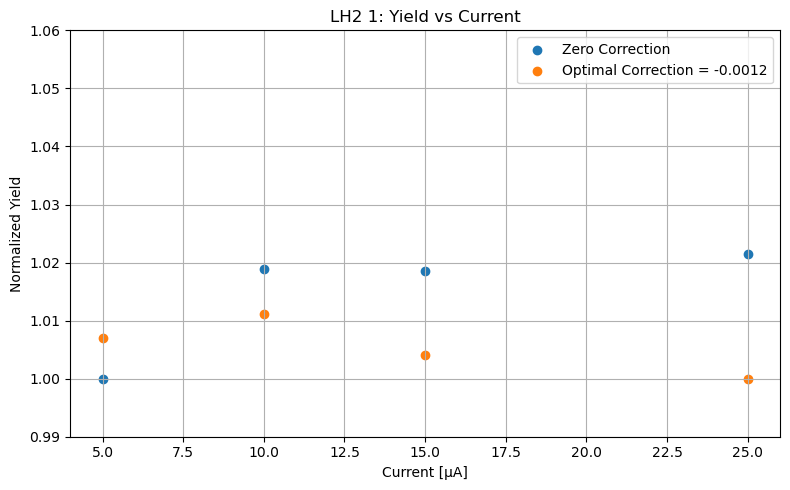


Processing dataset: LH2 2
  Zero Correction | Run 6850 at 5 uA
    Yield/Charge = 44.63657550812549
  Zero Correction | Run 6851 at 20 uA
    Yield/Charge = 45.0723871930222
  Zero Correction | Run 6852 at 15 uA
    Yield/Charge = 45.19897619304665
  Zero Correction | Run 6853 at 10 uA
    Yield/Charge = 45.148762549137004
  Zero Correction | Run 6854 at 3 uA
    Yield/Charge = 42.931078039665636
  Optimal Correction = -0.0012 | Run 6850 at 5 uA
    Yield/Charge = 46.89729482897855
  Optimal Correction = -0.0012 | Run 6851 at 20 uA
    Yield/Charge = 46.23627452625552
  Optimal Correction = -0.0012 | Run 6852 at 15 uA
    Yield/Charge = 46.556653185755934
  Optimal Correction = -0.0012 | Run 6853 at 10 uA
    Yield/Charge = 46.788193910466504
  Optimal Correction = -0.0012 | Run 6854 at 3 uA
    Yield/Charge = 45.605299771315984


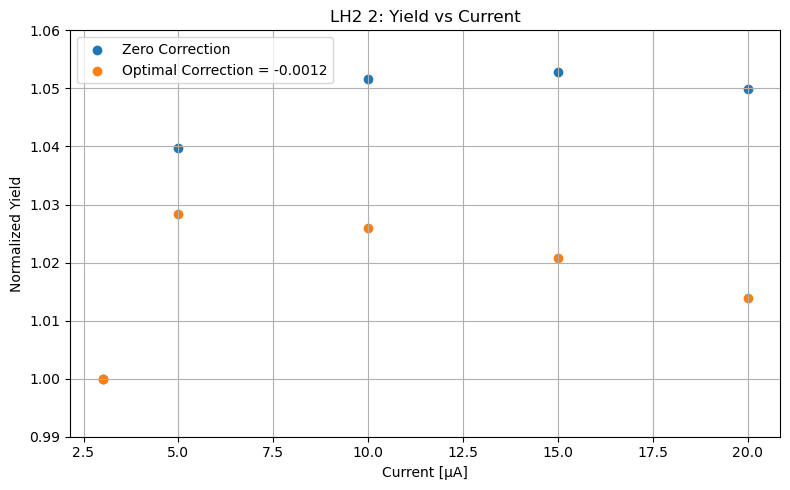


Processing dataset: LD2
  Zero Correction | Run 1518 at 40 uA
    Yield/Charge = 1029.8345452231747
  Zero Correction | Run 1519 at 25 uA
    Yield/Charge = 1029.3685625754451
  Zero Correction | Run 1520 at 18 uA
    Yield/Charge = 1031.1280767294265
  Zero Correction | Run 1521 at 10 uA
    Yield/Charge = 1023.4289590226175
  Zero Correction | Run 1522 at 5 uA
    Yield/Charge = 1006.404392253256
  Optimal Correction = -0.0012 | Run 1518 at 40 uA
    Yield/Charge = 1048.8938545304438
  Optimal Correction = -0.0012 | Run 1519 at 25 uA
    Yield/Charge = 1053.6572882699302
  Optimal Correction = -0.0012 | Run 1520 at 18 uA
    Yield/Charge = 1059.9694915517869
  Optimal Correction = -0.0012 | Run 1521 at 10 uA
    Yield/Charge = 1061.8709762455478
  Optimal Correction = -0.0012 | Run 1522 at 5 uA
    Yield/Charge = 1059.6303738017818


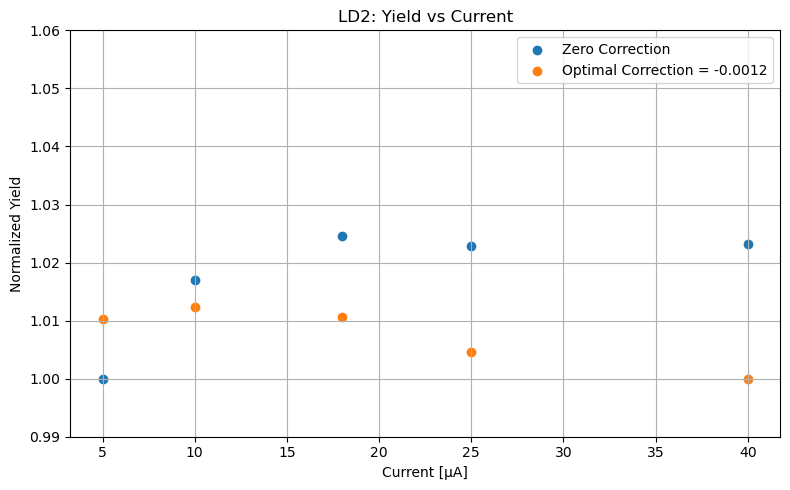

In [111]:
datasets = {
    "LH2 1": {
        "runs": [1514, 1515, 1516, 1517],
        "currents": [5, 10, 15, 25]
    },
    "LH2 2": {
        "runs": [6850, 6851, 6852, 6853, 6854],
        "currents": [5, 20, 15, 10, 3]
    },
    "LD2": {
        "runs": [1518, 1519, 1520, 1521, 1522],
        "currents": [40, 25, 18, 10, 5]
    }
}

corrections = {
    f"Zero Correction": 0.0,
    f"Optimal Correction = {optimal_correction:.4f}": optimal_correction  # Display value in legend
}

for label, data in datasets.items():
    print(f"\nProcessing dataset: {label}")
    
    plt.figure(figsize=(8, 5))

    for corr_label, correction in corrections.items():
        yields = []
        valid_currents = []

        for run, current in zip(data["runs"], data["currents"]):
            print(f'  {corr_label} | Run {run} at {current} uA')
            y = plot_yield_scaler(run, current, correction)
            if y > 0:
                yields.append(y)
                valid_currents.append(current)
                print(f'    Yield/Charge = {y}')
            else:
                print(f'    Invalid or zero yield')

        if yields:
            min_yield = min(yields)
            normalized_yields = [y / min_yield for y in yields]

            plt.scatter(valid_currents, normalized_yields, label=corr_label)

    plt.xlabel('Current [μA]')
    plt.ylabel('Normalized Yield')
    plt.title(f'{label}: Yield vs Current')
    plt.grid(True)
    plt.ylim(0.99, 1.06)
    plt.legend()
    plt.tight_layout()
    plt.show()
